Pois categories:
- entertainment
- commercial
- catering
- service
- office
- leisure
- natural
- education
- building.historic
- heritage
- tourism
- accomodation
- pet
- healthcare
- administrative
- production
- religion
- amenity
- public transport

Nodes features:
- crosswalk
- walk light
- round-about
- walk light duration
- street width
- tactile paving

Edges features:
- work in progress
- bike lane
- uphill
- surface
- one way
- tactile paving
- stairs

Pois features:
- wheelchair accessible
- tactile paving
- tactile map
- reception
- stairs
- elevators

In [36]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json

In [37]:
src = "detroit_conant"
out = f"{src}/{src}_out"

In [38]:
!python3.8 src/convert_new_york_pois.py  --src_dir "{src}"

Street not found: West 31st Street
New York references found in Prosek
New York references found in Grand Vista Hotel


In [39]:
fixes = {
    "Cooper Electric": "Joseph Campau Avenue",
    "The Lincoln Detroit": "Klinger Street",
    "Urban Fusion": "East Robinwood Street",
    "Wells Fargo": "East Grixdale Avenue",
    "Whole Foods Market": "East Grixdale Avenue",
    "Wolfgang’s Steakhouse": "Brinker Avenue",
}

with open(f"{src}/pois.json") as f:
    pois_raw = json.load(f)

for poi in pois_raw["features"]:
    poi = poi["properties"]
    if not "name" in poi:
        continue

    if poi["name"] in fixes:
        if "branch" in poi and poi["branch"] == poi["street"]:
            poi["branch"] = fixes[poi["name"]]
        poi["street"] = fixes[poi["name"]]

with open(f"{src}/pois.json", "w") as f:
    json.dump(pois_raw, f, indent=4)

In [40]:
!python3.8 src/format.py --name "Detroit, Conant Street" --n0 1 --n1 "(2, 42.43049082474931, -83.07592347811368)" --d_m 245.02 --src_dir "{src}"

Meters per pixel: 0.7377978833454896
Conant / 7 Mile (NB) is too close to node 76
Skipping POI without name at index 3
Skipping POI without name at index 6
Skipping POI without name at index 9
Skipping POI without name at index 13
Skipping POI without name at index 18


In [41]:
def distance(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

def get_label(name: str):
    name.replace("-", " ")
    name.replace("_", " ")

    label = ""
    for word in name.split(" "):
        if len(word) > 2 and word[:-2].isnumeric():
            label += word[:-2]
        else: label += word[0]
    return label

def get_contrasting_color(color):
    rgb = mcolors.to_rgb(color)
    brightness = 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]
    return 'white' if brightness < 0.5 else 'black'

In [42]:
G = nx.Graph()

with open(f'{out}/nodes.json') as f:
    nodes = json.load(f)

for i, node in enumerate(nodes):
    G.add_node(i, pos=(node[0], node[1]))

with open(f'{out}/edges.json') as f:
    edges = json.load(f)

with open(f'{out}/streets.json', 'r') as f:
    streets = json.load(f)

for street, street_edges in streets.items():
    street = street.replace("Street", "St")
    street = street.replace("Avenue", "Ave")
    street = street.replace("Boulevard", "Blvd")
    street = street.replace("Road", "Rd")

    for edge_index in street_edges:
        edge = edges[edge_index]

        n1 = G.nodes[edge[0]]['pos']
        n2 = G.nodes[edge[1]]['pos']
        dist = distance(n1, n2)
        G.add_edge(edge[0], edge[1], weight=dist, street=street)

with open(f'{out}/pois.json') as f:
    pois = json.load(f)
    pois.sort(key=lambda x: get_label(x['name']))

print(f"PoIs found: {len(pois)}")

PoIs found: 59


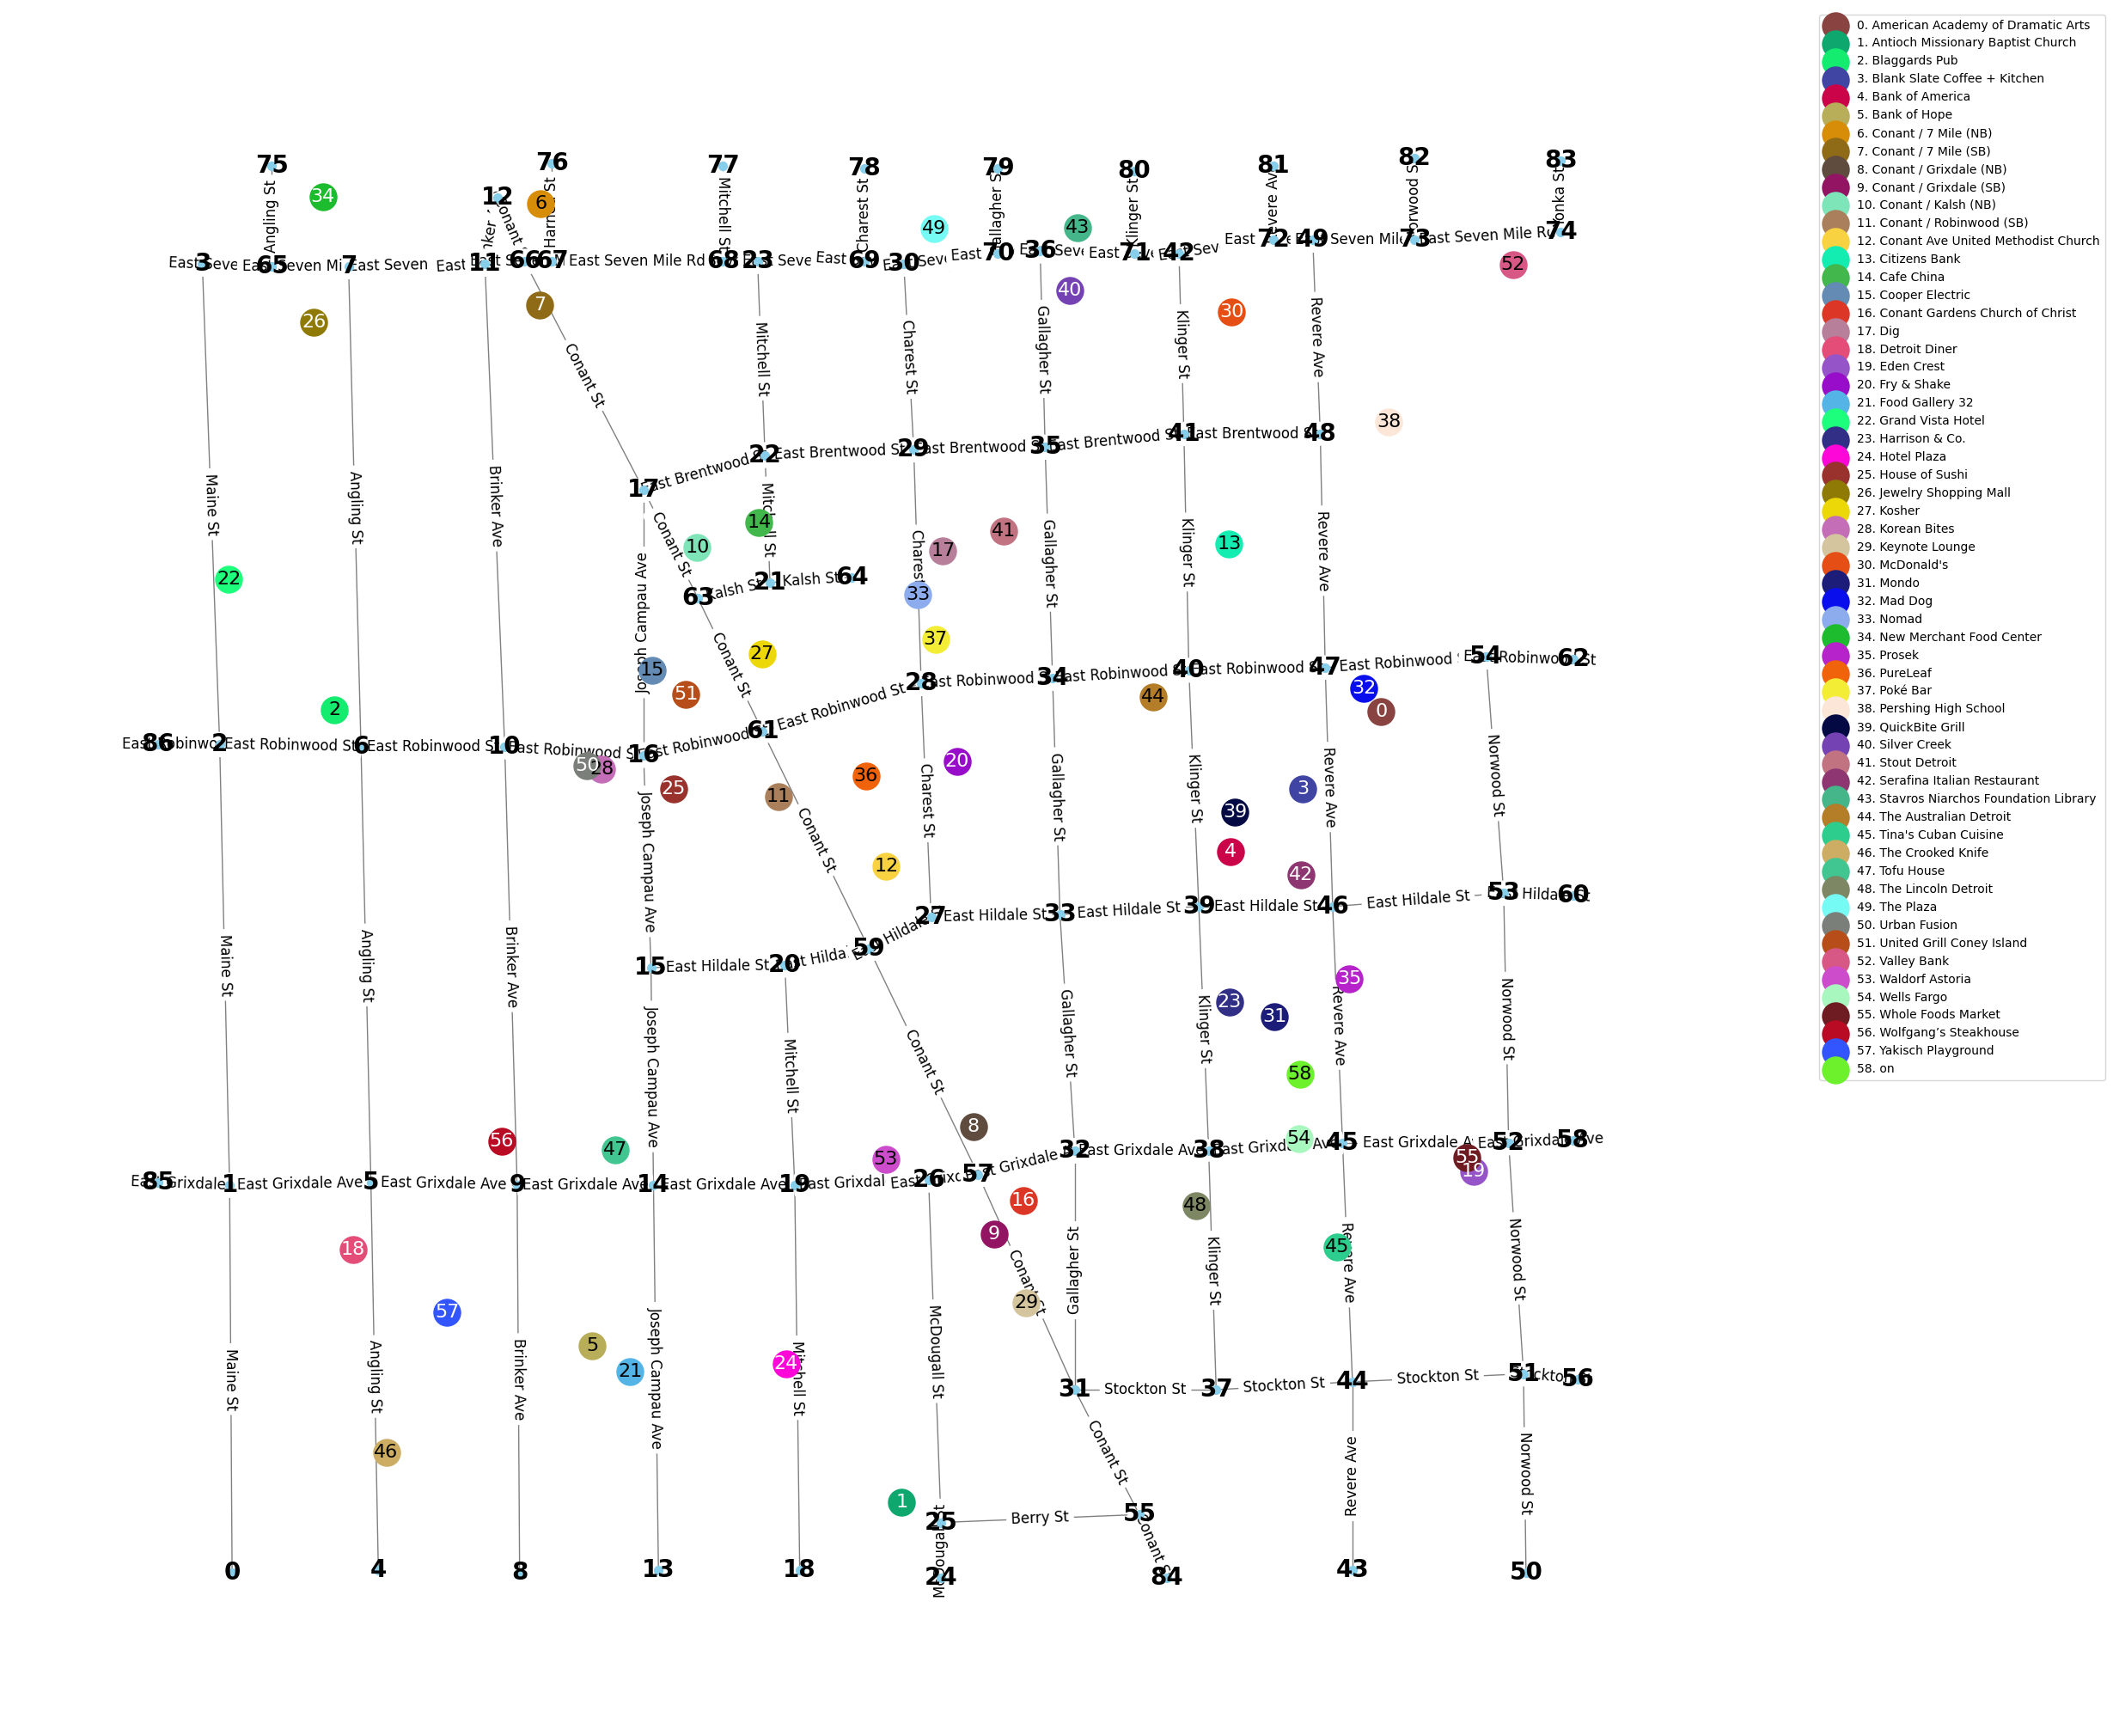

In [43]:
pos = nx.get_node_attributes(G, "pos")

plt.figure(figsize=(20, 20))

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=50,
    node_color="skyblue",
    font_size=20,
    font_color="black",
    font_weight="bold",
    edge_color="gray",
)

labels = nx.get_edge_attributes(G, "street")
#labels = {k: round(v, 2) for k, v in labels.items()}
#labels = {k: get_label(v) for k, v in labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12)

colors = np.random.rand(len(pois), 3)
for i, poi in enumerate(pois):
    coords = poi["coords"]
    dot = plt.scatter(
        coords[0], coords[1], color=colors[i], s=500, label=f"{i}. {poi['name']}"
    )
    text_color = get_contrasting_color(colors[i])
    plt.text(coords[0], coords[1], i, fontsize=16, c=text_color, ha="center", va="center")

plt.gca().invert_yaxis()
plt.gcf().set_size_inches(20, 20)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.savefig(f"{out}/plot.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

In [44]:
offset = 0
for i, poi in enumerate(pois[offset:]):
    print(f"{i + offset}. {poi['name']} - {edges[poi['edge']]}")

0. American Academy of Dramatic Arts - [46, 47]
1. Antioch Missionary Baptist Church - [25, 26]
2. Blaggards Pub - [2, 6]
3. Blank Slate Coffee + Kitchen - [46, 47]
4. Bank of America - [39, 40]
5. Bank of Hope - [13, 14]
6. Conant / 7 Mile (NB) - [66, 12]
7. Conant / 7 Mile (SB) - [17, 66]
8. Conant / Grixdale (NB) - [57, 59]
9. Conant / Grixdale (SB) - [31, 57]
10. Conant / Kalsh (NB) - [63, 17]
11. Conant / Robinwood (SB) - [59, 61]
12. Conant Ave United Methodist Church - [59, 61]
13. Citizens Bank - [40, 41]
14. Cafe China - [21, 22]
15. Cooper Electric - [16, 17]
16. Conant Gardens Church of Christ - [31, 57]
17. Dig - [28, 29]
18. Detroit Diner - [4, 5]
19. Eden Crest - [45, 52]
20. Fry & Shake - [27, 28]
21. Food Gallery 32 - [13, 14]
22. Grand Vista Hotel - [2, 3]
23. Harrison & Co. - [38, 39]
24. Hotel Plaza - [18, 19]
25. House of Sushi - [15, 16]
26. Jewelry Shopping Mall - [6, 7]
27. Kosher - [61, 63]
28. Korean Bites - [15, 16]
29. Keynote Lounge - [31, 57]
30. McDonald's